# **1: Installations**

In [1]:
!pip install --no-cache-dir rasterio kornia torch torchvision Pillow scikit-learn pandas tqdm matplotlib -q
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 271.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 259.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 309.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 270.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 227.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 277.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 279.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 279.0 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which

# **2: Training Data Download**

In [2]:
!wget --no-check-certificate https://madm.dfki.de/files/sentinel/EuroSATallBands.zip -O EuroSATallBands.zip
!unzip -q EuroSATallBands.zip -d EuroSAT

--2025-05-17 13:59:14--  https://madm.dfki.de/files/sentinel/EuroSATallBands.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 2067725275 (1.9G) [application/zip]
Saving to: ‘EuroSATallBands.zip’

EuroSATallBands.zip 100%[===================>]   1.92G  30.0MB/s    in 67s     

2025-05-17 14:00:21 (29.5 MB/s) - ‘EuroSATallBands.zip’ saved [2067725275/2067725275]



# **3: Convert .tif to .npy and band selection**

In [ ]:
import os
import numpy as np
import rasterio
from tqdm import tqdm

def convert_selected_bands_with_ndvi(
    src_root="EuroSAT/ds/images/remote_sensing/otherDatasets/sentinel_2/tif",
    dst_root="EuroSAT_npy_AllBands_NDVI"
):
    os.makedirs(dst_root, exist_ok=True)
    # All bands except B10 (index 9)
    selected_indices = [1,2,3,4,5,6,7,8,10,11,12]  # B1-B9, B11-B8a

    for class_name in tqdm(os.listdir(src_root)):
        src_class_path = os.path.join(src_root, class_name)
        dst_class_path = os.path.join(dst_root, class_name)
        os.makedirs(dst_class_path, exist_ok=True)

        for fname in os.listdir(src_class_path):
            if not fname.endswith(".tif"):
                continue
            path = os.path.join(src_class_path, fname)
            out_path = os.path.join(dst_class_path, fname.replace(".tif", ".npy"))

            try:
                with rasterio.open(path) as src:
                    img = src.read()
                    img = np.clip(img, 0, 10000).astype(np.float32)

                    # Raw bands (scaled to 0‑1)
                    raw_bands = img[selected_indices] / 10000.0

                    # Indices
                    B3, B4, B8, B11 = img[2], img[3], img[7], img[11]   # note: indices w.r.t selected set
                    ndvi = (B8 - B4) / (B8 + B4 + 1e-6)
                    ndwi = (B3 - B8) / (B3 + B8 + 1e-6)
                    ndbi = (B11 - B8) / (B11 + B8 + 1e-6)
                    ndmi = (B8 - B11) / (B8 + B11 + 1e-6)
                    savi = (1.5 * (B8 - B4)) / (B8 + B4 + 0.5)

                    indices = np.stack([ndvi, ndwi, ndbi, ndmi, savi], axis=0)
                    indices = np.clip(indices, -1, 1)

                    final = np.concatenate([raw_bands, indices], axis=0).astype(np.float32)
                    np.save(out_path, final)

            except Exception as e:
                print(f" Failed: {fname} | {e}")

    print(f" NPY files saved in {dst_root}")

convert_selected_bands_with_ndvi()

100%|██████████| 10/10 [01:25<00:00,  8.56s/it]

 NPY files saved in EuroSAT_npy_AllBands_NDVI


# **4: Dataset Preparation and Exploratory Data Analysis (EDA)**

# **4.1: Build Dataset Index + Compute Mean/Std**

In [4]:
import pandas as pd

def build_dataset_index(npy_root="EuroSAT_npy_AllBands_NDVI"):
    rows = []
    classes = sorted(os.listdir(npy_root))
    for cls in classes:
        for fname in os.listdir(os.path.join(npy_root, cls)):
            if fname.endswith(".npy"):
                rows.append({
                    "path": os.path.join(npy_root, cls, fname),
                    "label": cls
                })
    df = pd.DataFrame(rows)
    df['label_idx'] = df['label'].astype('category').cat.codes
    return df

df = build_dataset_index()

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)

def compute_mean_std(df):
    channel_sum = 0
    channel_squared_sum = 0
    total_pixels = 0

    for path in tqdm(df['path'], desc="Computing mean/std"):
        arr = np.load(path)
        c, h, w = arr.shape
        channel_sum += arr.sum(axis=(1, 2))
        channel_squared_sum += (arr ** 2).sum(axis=(1, 2))
        total_pixels += h * w

    mean = channel_sum / total_pixels
    std = np.sqrt(channel_squared_sum / total_pixels - mean ** 2)
    return mean.tolist(), std.tolist()

mean, std = compute_mean_std(df)
print("Mean:", mean)
print("Std:", std)

Computing mean/std: 100%|██████████| 27000/27000 [00:07<00:00, 3530.65it/s]

Mean: [0.111715087890625, 0.10418185763888889, 0.09464432327835648, 0.11991246202256944, 0.20029220920138888, 0.23738861762152777, 0.2301082718460648, 0.07321812156394676, 0.1820581958912037, 0.11181196650752315, 0.2599646990740741, 0.3485861906828704, -0.2825510344328704, -0.39882179542824076, 0.39882179542824076, 0.49681322337962963]
Std: [0.03314088879948445, 0.03930490176462523, 0.059183728028407566, 0.05657148098788042, 0.08597458990058802, 0.10856433945893296, 0.11165492719960055, 0.040372894570256244, 0.10013520380415815, 0.07593332017028735, 0.12302258053760556, 0.3300052518920216, 0.3387879986818727, 0.2728502039504326, 0.2728502039504326, 0.46377597150611255]


# **4.2: Dataset Class Visualization**

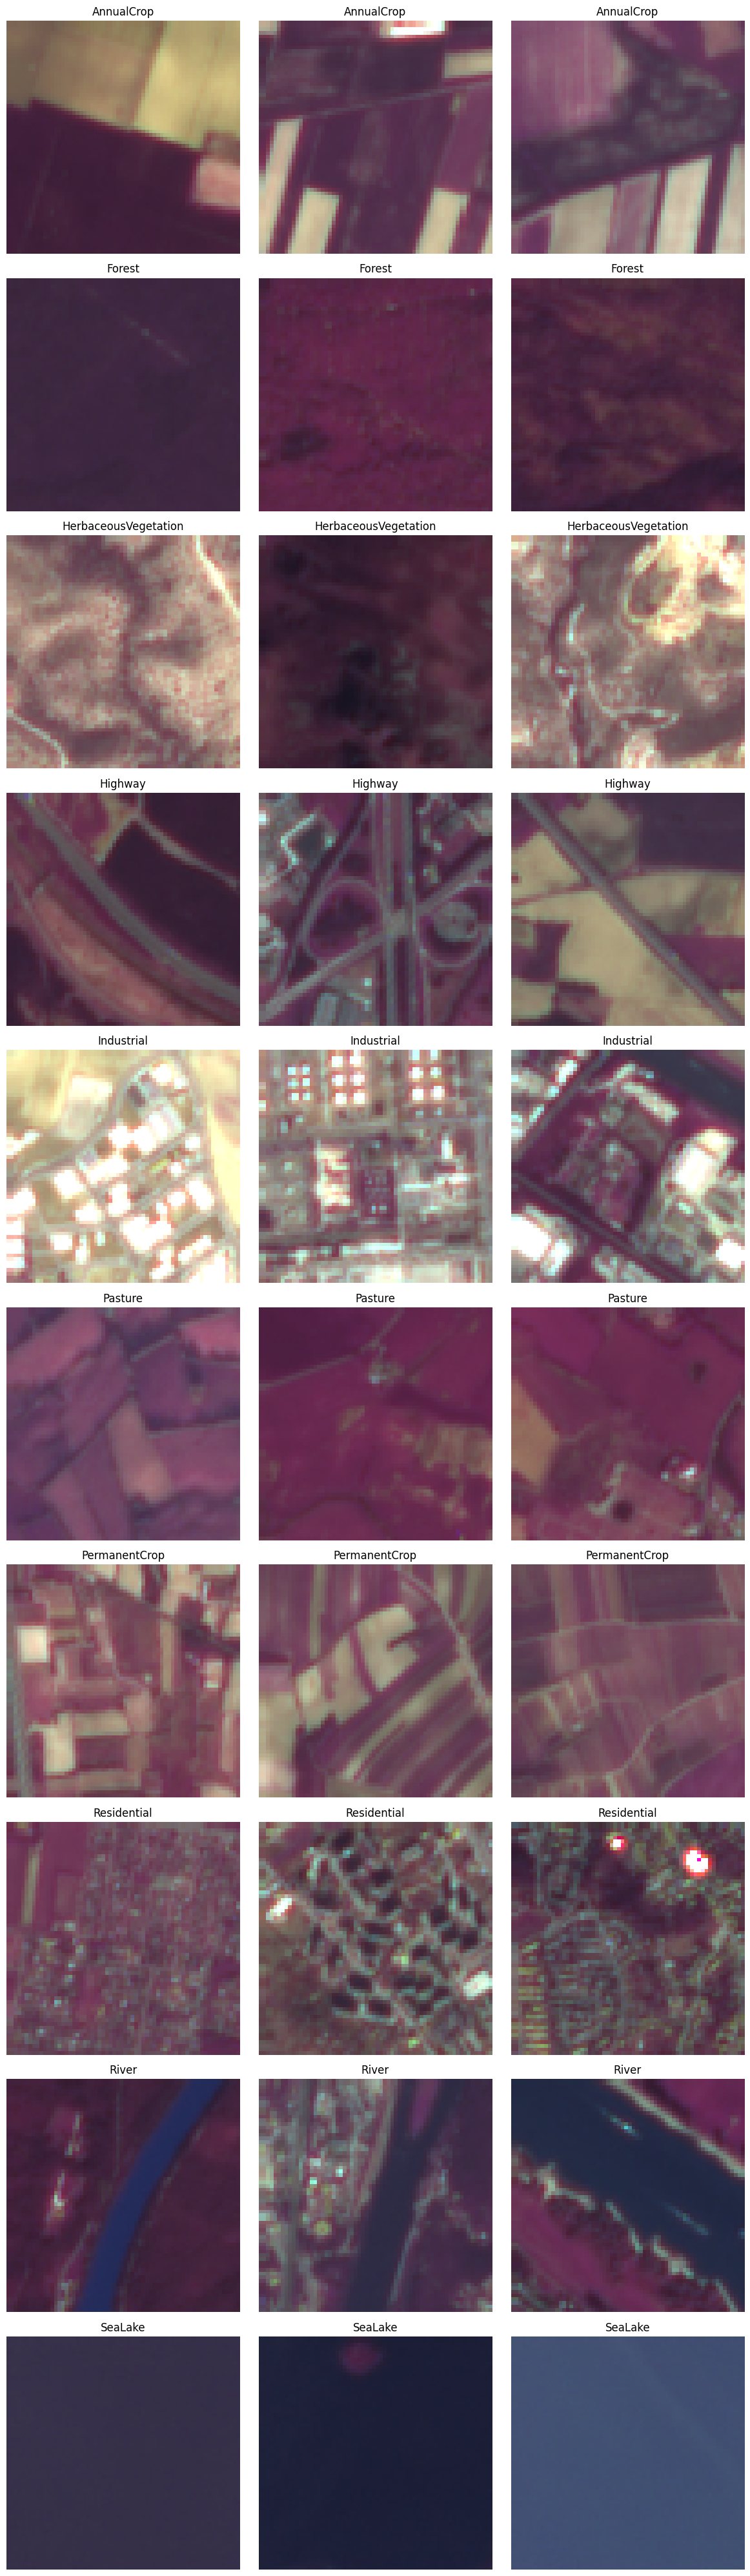

In [5]:
# Add after the dataset creation
import matplotlib.pyplot as plt

def visualize_classes(dataframe, npy_root="EuroSAT_npy_AllBands_NDVI", num_per_class=1):
    classes = sorted(dataframe['label'].unique())
    fig, axes = plt.subplots(len(classes), num_per_class, figsize=(4*num_per_class, 4*len(classes)))
    
    for i, class_name in enumerate(classes):
        class_samples = dataframe[dataframe['label'] == class_name]['path'].tolist()[:num_per_class]
        
        for j, sample_path in enumerate(class_samples):
            # Load the .npy file
            sample = np.load(sample_path)
            
            # Use RGB-like combination of bands (B4, B3, B2) for visualization
            # These correspond to Red, Green, Blue bands
            rgb_img = np.stack([
                sample[3],  # Red band (B4)
                sample[2],  # Green band (B3)
                sample[1],  # Blue band (B2)
            ], axis=2)
            
            # Normalize for visualization
            rgb_img = np.clip(rgb_img * 3.5, 0, 1)  # Enhance brightness
            
            ax = axes[i, j] if len(classes) > 1 else axes[j]
            ax.imshow(rgb_img)
            ax.set_title(class_name)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize one sample per class
visualize_classes(df, num_per_class=3)

# **4.3: Spectral Band Visualization**

Visualizing bands for: AnnualCrop


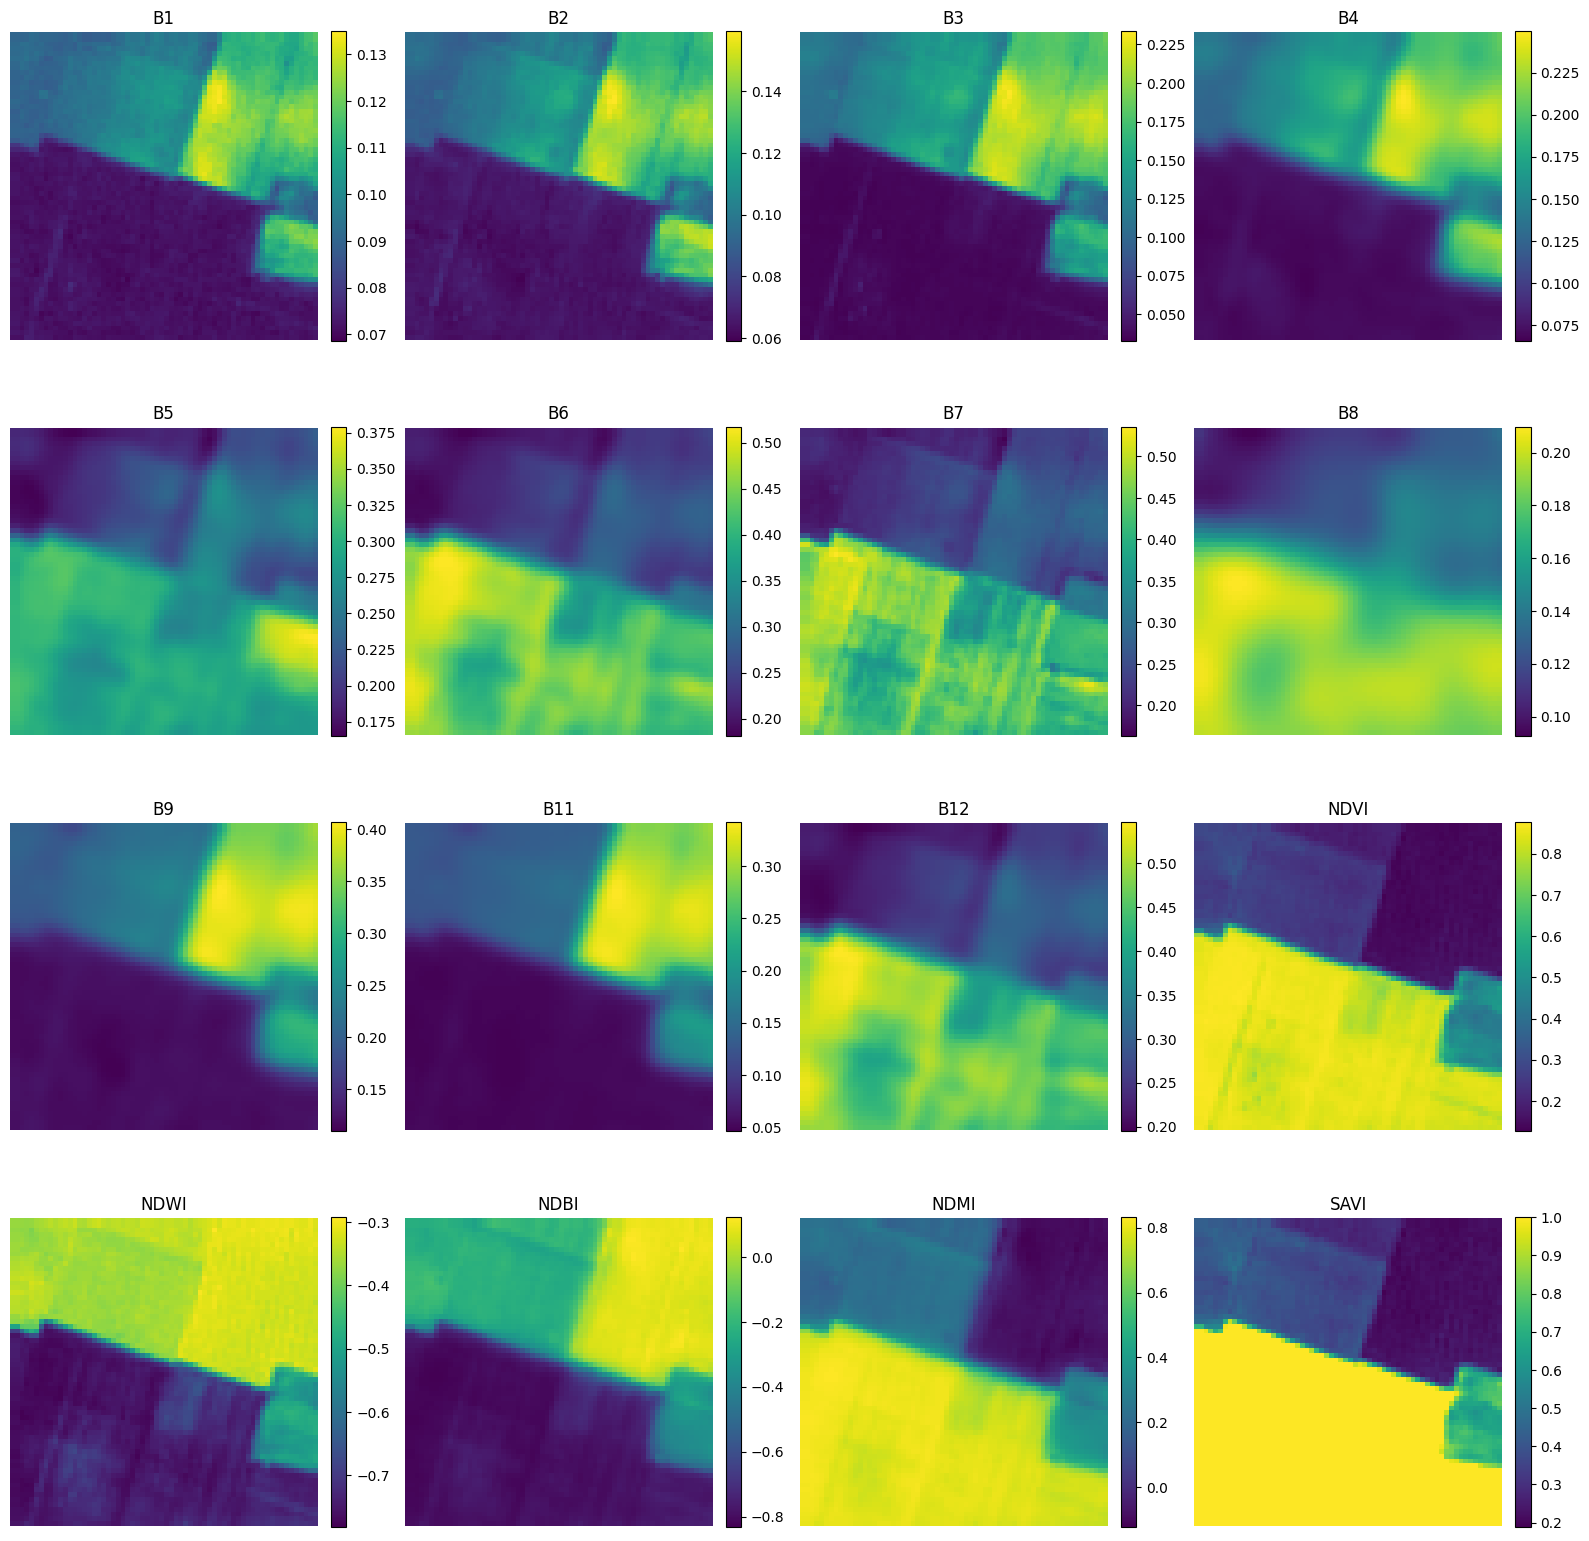

In [6]:
# Add after loading the dataset
def visualize_spectral_bands(sample_path):
    """Visualize different spectral bands of a single sample"""
    sample = np.load(sample_path)
    
    # Define band names
    band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 
                  'B7', 'B8', 'B9', 'B11', 'B12', 
                  'NDVI', 'NDWI', 'NDBI', 'NDMI', 'SAVI']
    
    # Plot the first 16 channels (raw bands + indices)
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.flatten()
    
    for i in range(min(16, sample.shape[0])):
        im = axes[i].imshow(sample[i], cmap='viridis')
        axes[i].set_title(band_names[i])
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Pick a sample image
sample_path = df.iloc[0]['path']
print(f"Visualizing bands for: {df.iloc[0]['label']}")
visualize_spectral_bands(sample_path)

# **4.4: Class Distribution Visualization**

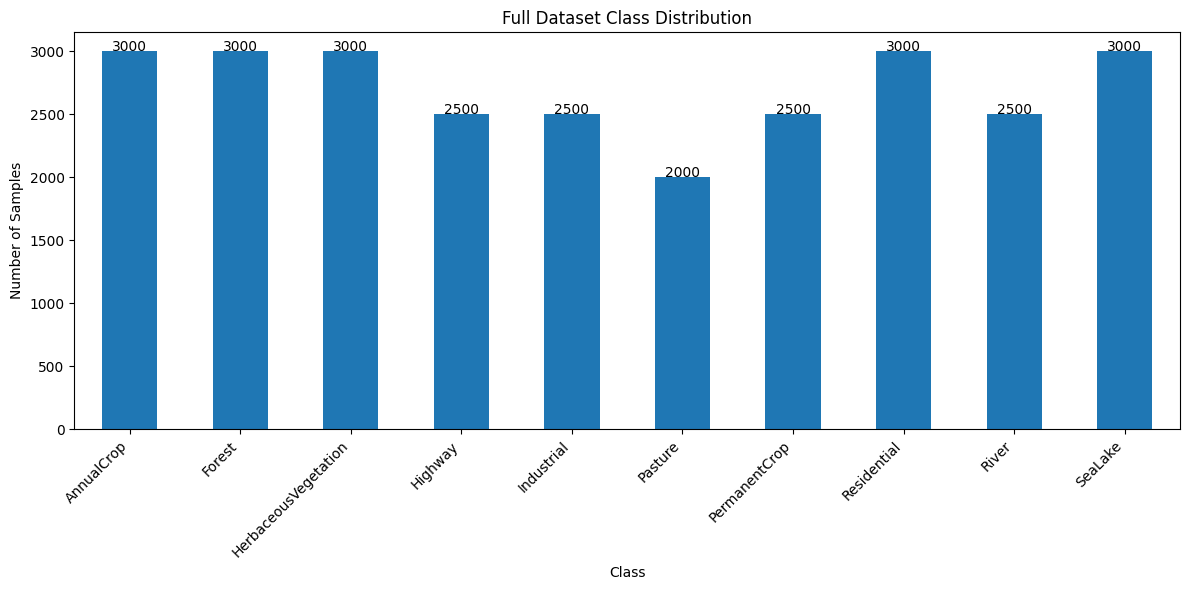

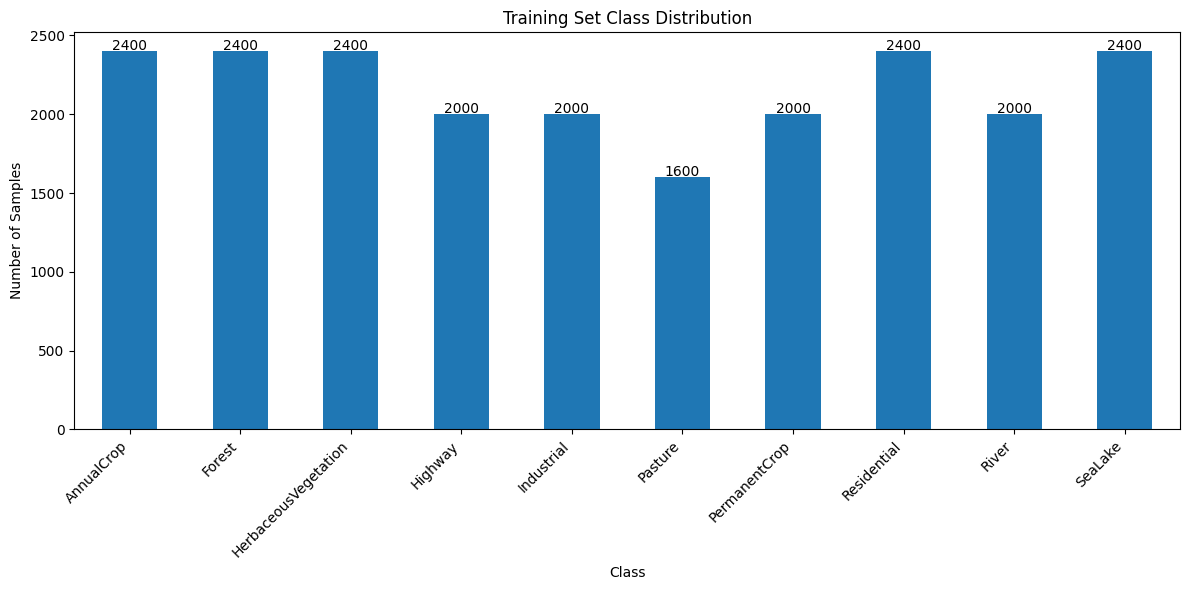

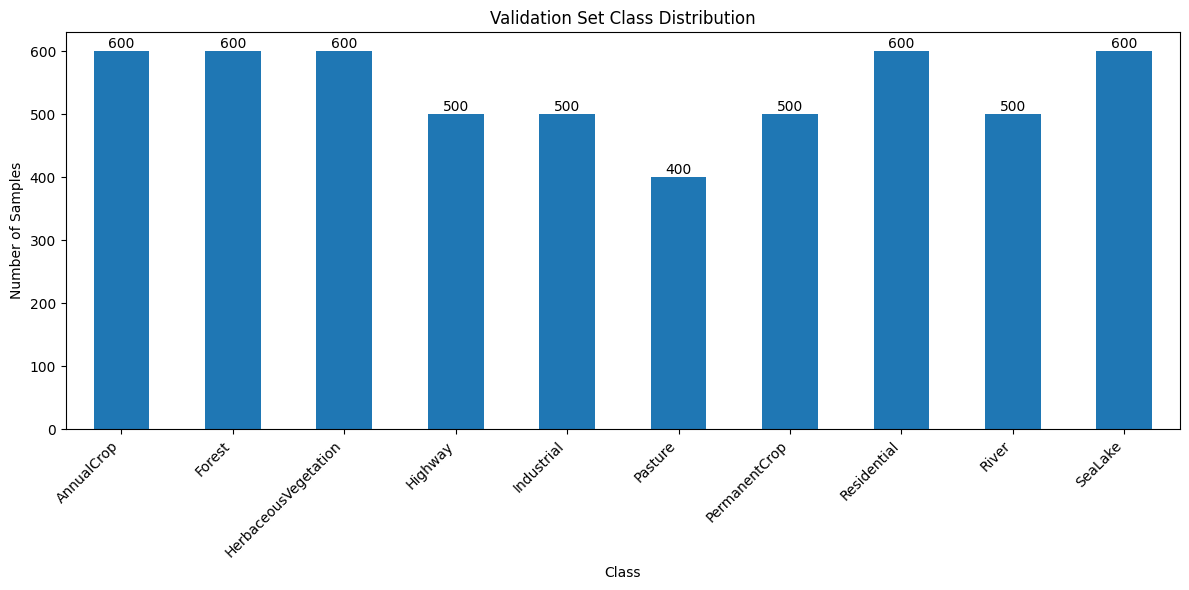

In [7]:
def plot_class_distribution(dataframe, title="Class Distribution"):
    """Visualize the distribution of classes in the dataset"""
    plt.figure(figsize=(12, 6))
    class_counts = dataframe['label'].value_counts().sort_index()
    ax = class_counts.plot(kind='bar')
    plt.title(title)
    plt.ylabel('Number of Samples')
    plt.xlabel('Class')
    plt.xticks(rotation=45, ha='right')
    
    # Add count labels on top of bars
    for i, count in enumerate(class_counts):
        ax.text(i, count + 5, str(count), ha='center')
    
    plt.tight_layout()
    plt.show()

# Plot distribution for entire dataset
plot_class_distribution(df, title="Full Dataset Class Distribution")

# Plot distribution for train/val splits
plot_class_distribution(train_df, title="Training Set Class Distribution")
plot_class_distribution(val_df, title="Validation Set Class Distribution")

# **5: Reproducibility and Data Augmentation Pipeline Setup**

# **5.1: Fix seeds**

In [8]:
import random
import numpy as np
import torch

seed = 45
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# **5.2: Augmentation**

In [9]:
import torch.optim as optim

In [10]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(60),
    transforms.Resize((64, 64)),
    #transforms.Normalize(mean=mean, std=std)
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    #transforms.Normalize(mean=mean, std=std)
])


# **5.3: Data Augmentation Visualization**

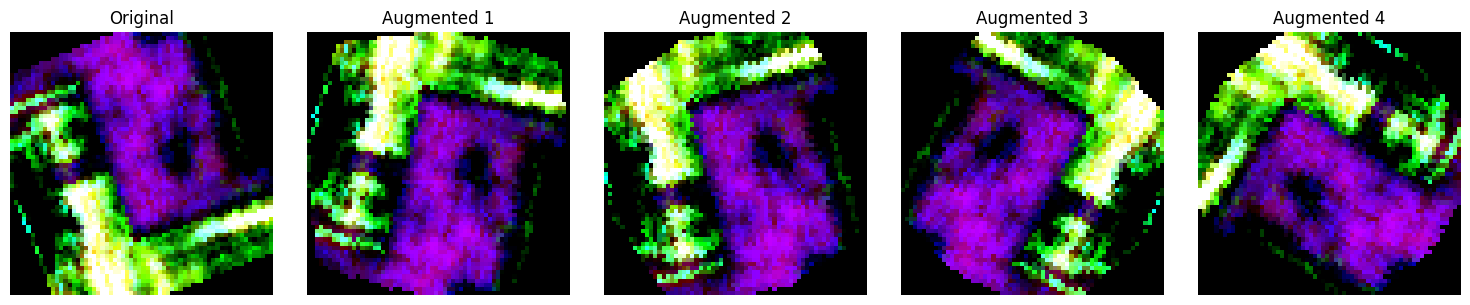

In [ ]:
# Add after defining transforms
# Run cell 6 before running cell 5.3
def visualize_augmentations(dataset, idx=0, num_augmentations=5):
    """Visualize the effect of augmentations on a single sample"""
    sample, _ = dataset[idx]
    
    fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(3*(num_augmentations+1), 3))
    
    # Original image (using RGB bands)
    rgb_img = np.stack([
        sample[3].numpy(),  # Red
        sample[2].numpy(),  # Green
        sample[1].numpy(),  # Blue
    ], axis=2)
    rgb_img = np.clip(rgb_img, 0, 1)
    
    axes[0].imshow(rgb_img)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Apply augmentation multiple times
    for i in range(num_augmentations):
        aug_sample = train_transform(sample)
        
        # Convert to RGB for visualization
        aug_rgb = np.stack([
            aug_sample[3].numpy(),  # Red
            aug_sample[2].numpy(),  # Green
            aug_sample[1].numpy(),  # Blue
        ], axis=2)
        aug_rgb = np.clip(aug_rgb, 0, 1)
        
        axes[i+1].imshow(aug_rgb)
        axes[i+1].set_title(f"Augmented {i+1}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize augmentations on a sample
visualize_augmentations(train_ds, idx=0, num_augmentations=4)

# **6: Data Preparation: Dataset and DataLoader Creation**

In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

train_df, val_df = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)

class EuroSATDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sample = np.load(row['path']).astype(np.float32)
        sample = torch.tensor(sample)

        # Calculate mean and std per sample
        mean = sample.mean(dim=[1, 2], keepdim=True)
        std = sample.std(dim=[1, 2], keepdim=True)

        # Normalize the sample
        sample = (sample - mean) / (std + 1e-5)  # Adding a small constant to avoid division by zero

        if self.transform:
            sample = self.transform(sample)

        label = torch.tensor(row['label_idx'], dtype=torch.long)
        return sample, label

train_ds = EuroSATDataset(train_df, transform=train_transform)
val_ds = EuroSATDataset(val_df, transform=val_transform)

train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True,
    num_workers=2, prefetch_factor=4, pin_memory=True
)

val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False,
    num_workers=2, prefetch_factor=4, pin_memory=True
)

# **7: Model Definition and Architecture Details**

# **7.1: Define and Initialize Custom ResNet50 Model (Pretrained = False)**

In [14]:
from torchvision import models
import torch.nn as nn
import torch

from torchvision import models
import torch.nn as nn
import torch

class ResNet50_MultiChannel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet50(weights=None)
        # Modify first conv layer to accept 16 channels
        self.model.conv1 = nn.Conv2d(16, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50_MultiChannel(num_classes=df['label_idx'].nunique())

if torch.cuda.device_count() > 1:
    print(f" Using {torch.cuda.device_count()} GPUs via DataParallel")
    model = nn.DataParallel(model)

model = model.to(device)

 Using 2 GPUs via DataParallel


# **7.2: Visualize Model Architecture and Parameters**

In [15]:
from torchinfo import summary
import torch.nn as nn

def visualize_model_architecture(model):
    """Create a text-based summary of model architecture"""
    # Create a sample input size matching your data
    input_size = (1, 16, 64, 64)
    
    # Generate comprehensive summary
    model_stats = summary(
        model, 
        input_size=input_size,
        col_names=["input_size", "output_size", "num_params", "kernel_size"],
        depth=3,
        verbose=1
    )
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    return model_stats
    
visualize_model_architecture(model)

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
DataParallel                                       [1, 16, 64, 64]           [1, 10]                   --                        --
├─ResNet50_MultiChannel: 1-1                       [1, 16, 64, 64]           [1, 10]                   23,569,290                --
├─ResNet50_MultiChannel: 1-2                       --                        --                        --                        --
│    └─ResNet: 2-1                                 [1, 16, 64, 64]           [1, 10]                   23,569,290                --
│    └─ResNet: 2-2                                 --                        --                        --                        --
│    │    └─Conv2d: 3-1                            [1, 16, 64, 64]           [1, 64, 32, 32]           50,176                    [7, 7]
│    │    └─BatchNorm2d: 3-2                       [1, 64, 32,

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
DataParallel                                       [1, 16, 64, 64]           [1, 10]                   --                        --
├─ResNet50_MultiChannel: 1-1                       [1, 16, 64, 64]           [1, 10]                   23,569,290                --
├─ResNet50_MultiChannel: 1-2                       --                        --                        --                        --
│    └─ResNet: 2-1                                 [1, 16, 64, 64]           [1, 10]                   23,569,290                --
│    └─ResNet: 2-2                                 --                        --                        --                        --
│    │    └─Conv2d: 3-1                            [1, 16, 64, 64]           [1, 64, 32, 32]           50,176                    [7, 7]
│    │    └─BatchNorm2d: 3-2                       [1, 64, 32,

# **8: Configure Core Training Components**

In [16]:
import torch.optim as optim 
import torch.nn as nn 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5, weight_decay=1e-5) # Added weight_decay as in original training loop


# **9: Define Training and Validation Helper Functions**

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def train_one_epoch(model, loader, optimizer, criterion, device, epoch, log_interval=10):
    model.train()
    total_loss, correct, total = 0, 0, 0
    batch_loss = 0

    for batch_idx, (x, y) in enumerate(loader, 1):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        batch_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

        if batch_idx % log_interval == 0:
            avg_loss = batch_loss / log_interval
            print(f"[Epoch {epoch}] Batch {batch_idx:04d} - Avg Loss: {avg_loss:.4f}")
            batch_loss = 0

    return total_loss / total, correct / total

def validate(model, loader, criterion, device, class_names):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(out.argmax(1).cpu().numpy())

    val_acc = correct / total
    print(f"\n Val Acc: {val_acc * 100:.2f}%\n")
    print(" Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return total_loss / total, val_acc

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix of model predictions using only matplotlib"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    
    # Create heatmap with matplotlib instead of seaborn
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Set tick marks and labels
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()

# **10: Model Training**

# **10.1: Training Function**

In [18]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Ensure the following are defined in previous cells:
# - ResNet50_MultiChannel (your model class)
# - train_one_epoch (your function for training one epoch)
# - validate (your function for validation)
# You will also need to pass your training Dataset object (e.g., train_ds)
# to the 'train_ds_for_mapping' parameter of the run_training function.

def run_training(train_loader, val_loader, df, train_ds_for_mapping, num_epochs=10):
    # Define the directory for saving models in Kaggle's output
    kaggle_output_dir = "/kaggle/working/"
    models_save_folder = "Saved Models"
    full_models_path = os.path.join(kaggle_output_dir, models_save_folder)
    
    # Create the directory if it doesn't exist
    os.makedirs(full_models_path, exist_ok=True)
    print(f"Models will be saved in: {os.path.abspath(full_models_path)}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize model
    # Ensure ResNet50_MultiChannel is defined in a previous cell
    model = ResNet50_MultiChannel(num_classes=df['label_idx'].nunique())

    if torch.cuda.device_count() > 1:
        print(f" Using {torch.cuda.device_count()} GPUs via DataParallel")
        model = nn.DataParallel(model)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # Lists to store metrics for plotting
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    class_names = sorted(df['label'].unique())
    best_val_acc_tracker = 0.0 # To track overall best accuracy for a final message

    for epoch in range(1, num_epochs + 1):
        print(f"\n--- Epoch {epoch}/{num_epochs} ---")
        
        # Ensure train_one_epoch and validate functions are defined in previous cells
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch)
        val_loss, val_acc = validate(model, val_loader, criterion, device, class_names)

        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc * 100:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")

        # Save the model for the current epoch
        model_filename = f"model_epoch_{epoch:02d}.pth"
        model_filepath = os.path.join(full_models_path, model_filename)
        
        # Handle DataParallel model state saving
        model_state_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        
        torch.save({
            'epoch': epoch,
            'model_state': model_state_to_save,
            'optimizer_state': optimizer.state_dict(),
            'val_accuracy': val_acc, # Current epoch's validation accuracy
            'class_to_idx': train_ds_for_mapping.df[["label", "label_idx"]]
                              .drop_duplicates()
                              .set_index("label_idx")["label"]
                              .to_dict()
        }, model_filepath)
        print(f"Saved model for epoch {epoch} to {model_filepath}")

        if val_acc > best_val_acc_tracker:
            best_val_acc_tracker = val_acc
            # Optional: Announce if this epoch is the new best so far
            print(f"🎉 New best validation accuracy recorded: {best_val_acc_tracker*100:.2f}%")

    print(f"\nTraining complete. Overall best validation accuracy achieved during training: {best_val_acc_tracker*100:.2f}%")
    plot_training_progress(train_losses, val_losses, train_accs, val_accs)


def plot_training_progress(train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
    axes[0].plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(range(1, len(train_accs) + 1), [acc * 100 for acc in train_accs], 'b-', label='Training Accuracy')
    axes[1].plot(range(1, len(val_accs) + 1), [acc * 100 for acc in val_accs], 'r-', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# **10.2: Lights out 🚦and away we go 🏁🏎️**

Models will be saved in: /kaggle/working/Saved Models
 Using 2 GPUs via DataParallel

--- Epoch 1/20 ---
[Epoch 1] Batch 0010 - Avg Loss: 2.3643
[Epoch 1] Batch 0020 - Avg Loss: 2.2835
[Epoch 1] Batch 0030 - Avg Loss: 2.2606
[Epoch 1] Batch 0040 - Avg Loss: 2.2900
[Epoch 1] Batch 0050 - Avg Loss: 2.2408
[Epoch 1] Batch 0060 - Avg Loss: 2.2206
[Epoch 1] Batch 0070 - Avg Loss: 2.2437
[Epoch 1] Batch 0080 - Avg Loss: 2.1746
[Epoch 1] Batch 0090 - Avg Loss: 2.1489
[Epoch 1] Batch 0100 - Avg Loss: 2.1625
[Epoch 1] Batch 0110 - Avg Loss: 2.1715
[Epoch 1] Batch 0120 - Avg Loss: 2.1158
[Epoch 1] Batch 0130 - Avg Loss: 2.0659
[Epoch 1] Batch 0140 - Avg Loss: 2.0720
[Epoch 1] Batch 0150 - Avg Loss: 2.0263
[Epoch 1] Batch 0160 - Avg Loss: 2.0058
[Epoch 1] Batch 0170 - Avg Loss: 1.9513
[Epoch 1] Batch 0180 - Avg Loss: 1.9022
[Epoch 1] Batch 0190 - Avg Loss: 1.8579
[Epoch 1] Batch 0200 - Avg Loss: 1.9610
[Epoch 1] Batch 0210 - Avg Loss: 1.8116
[Epoch 1] Batch 0220 - Avg Loss: 1.8174
[Epoch 1] Batch

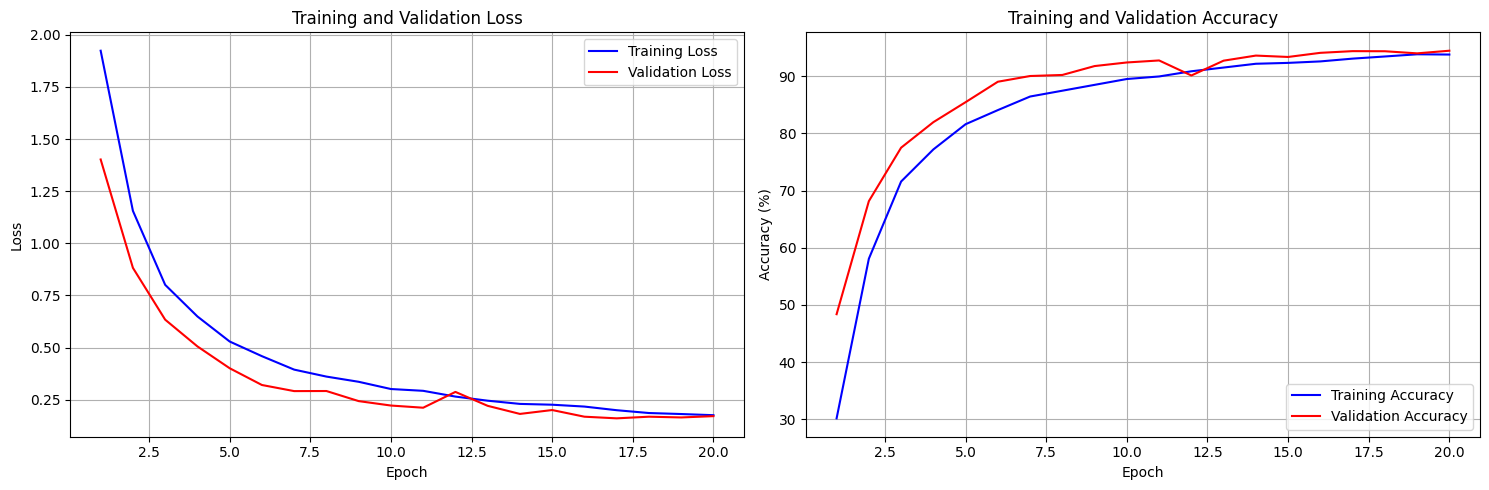

In [19]:
run_training(train_loader, val_loader, df, train_ds, num_epochs=20)

# **11: Inference + Submission**

# **11.1: Load Best Model**

In [20]:
best_model_path = "/kaggle/working/Saved Models/model_epoch_17.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1️⃣  Load the checkpoint
ckpt = torch.load(best_model_path, map_location=device)

# 2️⃣  Get the actual weight dict
state_dict = ckpt.get("state_dict", ckpt)          # Lightning-style or plain

# 3️⃣  Clean up the keys
clean_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("module."): k = k[7:]          # drop 'module.'
    if k.startswith("model."):  k = k[6:]          # drop 'model.'
    clean_state_dict[k] = v

# 4️⃣  Build the model and load weights (non-strict so extras are ignored)
model = ResNet50_MultiChannel(num_classes=df["label_idx"].nunique())
missing, unexpected = model.load_state_dict(clean_state_dict, strict=False)

print("Missing keys :", missing)      # should be [] if arch is identical
print("Unexpected   :", unexpected)   # safely ignored

model.to(device).eval()

/tmp/ipykernel_31/96680586.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path, map_location=device)


Missing keys : ['model.conv1.weight', 'model.bn1.weight', 'model.bn1.bias', 'model.bn1.running_mean', 'model.bn1.running_var', 'model.layer1.0.conv1.weight', 'model.layer1.0.bn1.weight', 'model.layer1.0.bn1.bias', 'model.layer1.0.bn1.running_mean', 'model.layer1.0.bn1.running_var', 'model.layer1.0.conv2.weight', 'model.layer1.0.bn2.weight', 'model.layer1.0.bn2.bias', 'model.layer1.0.bn2.running_mean', 'model.layer1.0.bn2.running_var', 'model.layer1.0.conv3.weight', 'model.layer1.0.bn3.weight', 'model.layer1.0.bn3.bias', 'model.layer1.0.bn3.running_mean', 'model.layer1.0.bn3.running_var', 'model.layer1.0.downsample.0.weight', 'model.layer1.0.downsample.1.weight', 'model.layer1.0.downsample.1.bias', 'model.layer1.0.downsample.1.running_mean', 'model.layer1.0.downsample.1.running_var', 'model.layer1.1.conv1.weight', 'model.layer1.1.bn1.weight', 'model.layer1.1.bn1.bias', 'model.layer1.1.bn1.running_mean', 'model.layer1.1.bn1.running_var', 'model.layer1.1.conv2.weight', 'model.layer1.1.bn2

ResNet50_MultiChannel(
  (model): ResNet(
    (conv1): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

# **11.2: Build Class Index → Label Mapping**

In [ ]:
##idx_to_class = {v: k for k, v in df[['label', 'label_idx']].drop_duplicates().set_index('label').to_dict()['label_idx'].items()}


# **11.3: Load Test Data**

In [21]:
test_dir = "/kaggle/input/testset/testset/testset" 

In [22]:
import os
from glob import glob

print("Exists:", os.path.exists(test_dir))
print("Files found:", len(glob(os.path.join(test_dir, "*.npy"))))

Exists: True
Files found: 4232


In [ ]:
# mean = torch.tensor([0.1821, 0.2301, 0.0946, 0.3486], device=device).view(4, 1, 1)
# std = torch.tensor([0.1001, 0.1117, 0.0592, 0.3300], device=device).view(4, 1, 1)


# **11.4: Inference Run**

In [ ]:
import os
import numpy as np
import torch
from tqdm import tqdm

test_dir = "/kaggle/input/testset/testset/testset"
ckpt = torch.load("/kaggle/working/Saved Models/model_epoch_15.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
idx_to_class = ckpt["class_to_idx"]      # <-- guaranteed to match training
model.eval()
test_files = sorted(glob(os.path.join(test_dir, "*.npy")))

#mean = torch.tensor([0.1821, 0.2301, 0.0946, 0.3486], device=device).view(4, 1, 1)
#std = torch.tensor([0.1001, 0.1117, 0.0592, 0.3300], device=device).view(4, 1, 1)

results = []

def process_test_data(path):
    x = np.load(path).astype(np.float32)
    x = np.transpose(x, (2, 0, 1))
    # No transpose needed, assuming the input is (C, H, W) after loading

    # Raw bands (scaled to 0-1)
    selected_indices = [1,2,3,4,5,6,7,9,10,11,8]   # B1-B9, B11-B8a
    raw_bands = x[selected_indices] / 10000.0

    # Indices
    B3, B4, B8, B11 = x[2], x[3], x[7], x[11]   # note: indices w.r.t selected set
    ndvi = (B8 - B4) / (B8 + B4 + 1e-6)
    ndwi = (B3 - B8) / (B3 + B8 + 1e-6)
    ndbi = (B11 - B8) / (B11 + B8 + 1e-6)
    ndmi = (B8 - B11) / (B8 + B11 + 1e-6)
    savi = (1.5 * (B8 - B4)) / (B8 + B4 + 0.5)


    indices = np.stack([ndvi, ndwi, ndbi, ndmi, savi], axis=0)
    indices = np.clip(indices, -1, 1)

    x_final = np.concatenate([raw_bands, indices], axis=0).astype(np.float32)
    x_final = torch.tensor(x_final)

    #x_final = torch.nn.functional.interpolate(
     #       torch.tensor(x_final).unsqueeze(0),
      #      size=(64, 64),
       #     mode="bilinear",
        #    align_corners=False
         # ).squeeze(0)

    # Calculate mean and std per sample
    mean = x_final.mean(dim=[1, 2], keepdim=True)
    std = x_final.std(dim=[1, 2], keepdim=True)

    # Normalize the sample
    x_final = (x_final - mean) / (std + 1e-5)  # Adding a small constant to avoid division by zero

    return x_final


# Update inference loop
with torch.no_grad():
    for path in tqdm(test_files, desc="Running Inference"):
        x_final = process_test_data(path)
        x_final = x_final.to(device, dtype=torch.float32)
        x_final = x_final.unsqueeze(0)

        out = model(x_final)
        pred = out.argmax(1).item()
        label = idx_to_class[pred]
        results.append((os.path.basename(path).replace(".npy", ""), label))

/tmp/ipykernel_31/717848525.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/kaggle/working/Saved Models/model_epoch_15.pth", map_location=device)
Run

# **11.5. Submission Generation**

In [35]:
import pandas as pd

# 'results' contains tuples like: [('test_0', 'Forest'), ('test_1', 'River'), ...]

# Convert to DataFrame with correct format
submission_df = pd.DataFrame(results, columns=["test_id", "label"])

# Extract numeric part of test_id and convert to int
submission_df["test_id"] = submission_df["test_id"].str.extract(r"(\d+)").astype(int)

# Sort by test_id to match sample_submission.csv order
submission_df = submission_df.sort_values("test_id").reset_index(drop=True)

# Save to CSV
submission_df.to_csv("Submission_selftrained_ep15.csv", index=False)

# **11.6: Class Counter**

In [32]:
from collections import Counter

# Extract just the predicted labels
predicted_labels = [label for _, label in results]

# Count occurrences of each class
class_counts = Counter(predicted_labels)

# Get all possible classes (in case some are missing from predictions)
all_classes = sorted(idx_to_class.values())

print("\nPredicted class distribution:")
for class_name in all_classes:
    count = class_counts.get(class_name, 0)
    print(f"{class_name}: {count}")


Predicted class distribution:
AnnualCrop: 464
Forest: 325
HerbaceousVegetation: 182
Highway: 715
Industrial: 147
Pasture: 989
PermanentCrop: 117
Residential: 280
River: 135
SeaLake: 878


# **11.6: Test Prediction Distribution**

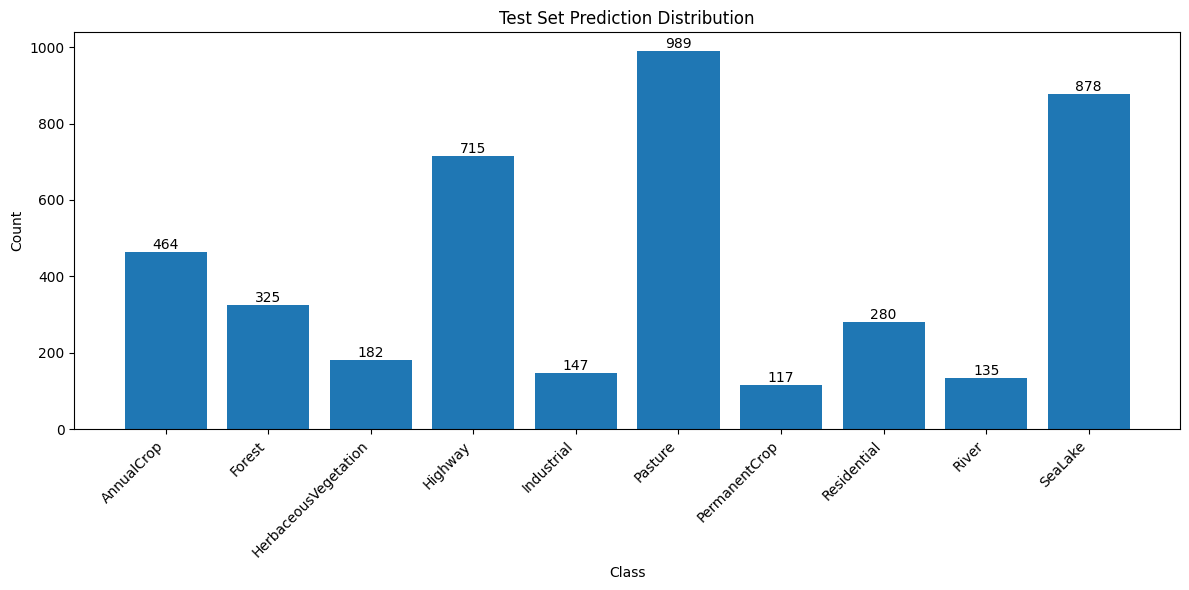

In [33]:
# Add after calculating class counts
def plot_test_distribution(class_counts, all_classes):
    """Plot distribution of predicted classes in test set"""
    plt.figure(figsize=(12, 6))
    counts = [class_counts.get(cls, 0) for cls in all_classes]
    
    bars = plt.bar(all_classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Test Set Prediction Distribution')
    plt.xticks(rotation=45, ha='right')
    
    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Plot test prediction distribution
plot_test_distribution(class_counts, all_classes)